In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from chewc.core import *


In [ ]:
#| hide
from chewc.core import *
from chewc.trait import *
from chewc.meiosis import *
from chewc.crossing import *


import torch
import attr
import matplotlib.pyplot as plt


# ChewC

> Pytorch Breeding

In short, this will be a GPU-enabled stochastic simulation for breeding programs with an emphasis on cost-benefit-analysis for novel breeding tools and creating a suitable interface for RL agents.


---
We will also incorporate an emphasis on budget and costs associated with each action to manage long-term breeding budgets. As well as model theoretical tools in the plant breeder's toolbox. e.g.

> a treatment which increases crossover rates

> a treatment which reduces flowering time

> a treatment which enables gene drive at select loci

Each treatment will cost $$ ultimately helping guide the implementation in real-world breeding programs.


## Install

```sh
pip install chewc
```

## How to use

First, define the genome of your crop

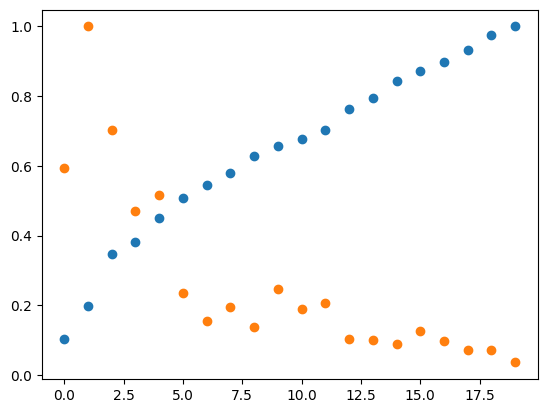

In [ ]:
import random

ploidy = 2
number_chromosomes = 10
loci_per_chromosome = 100
genetic_map = create_random_genetic_map(number_chromosomes,loci_per_chromosome)
crop_genome = Genome(ploidy, number_chromosomes, loci_per_chromosome, genetic_map)

n_founders = 500
founder_pop = create_random_founder_pop(crop_genome , n_founders)
sim_param = SimParam
sim_param.founder_pop = founder_pop
sim_param.genome = crop_genome


#add a single additive trait
qtl_loci = 20
qtl_map = select_qtl_loci(qtl_loci,sim_param.genome)

ta = TraitA(qtl_map,sim_param,0, 1)
ta.sample_initial_effects()
ta.scale_genetic_effects()
ta.calculate_intercept()






# Ensure sim_param.device is defined and correct
device = sim_param.device

years = 20
current_pop = founder_pop.to(device)
pmean = []
pvar = []

for _ in range(years):
    # phenotype current pop
    TOPK = 10
    new_pop = []
    pheno = ta.phenotype(current_pop, h2=0.14).to(device)
    topk = torch.topk(pheno, TOPK).indices.to(device)

    for _ in range(200):
        sampled_indices = torch.multinomial(torch.ones(topk.size(0), device=device), 2, replacement=False)
        sampled_parents = topk[sampled_indices]
        m, f = current_pop[sampled_parents[0]], current_pop[sampled_parents[1]]
        new_pop.append(make_cross(sim_param, m, f).to(device))
    
    current_pop = torch.stack(new_pop).to(device)
    pmean.append(ta.calculate_genetic_values(current_pop).mean().item())
    pvar.append(ta.calculate_genetic_values(current_pop).var().item())

pmean_normalized = torch.tensor(pmean, device=device) / max(pmean)
pvar_normalized = torch.tensor(pvar, device=device) / max(pvar)

plt.scatter(range(len(pmean_normalized)), pmean_normalized.cpu())
plt.scatter(range(len(pvar_normalized)), pvar_normalized.cpu())
plt.show()